<a id='Top'></a>

# <u>Computational Essay </u>
# Simulering av partikler og bølger på micrometer skala

## Introduksjon

I dette Comp. essayet skal vi undersøke hvorvidt det er mulig å simulere en bølge som reiser i et medium ved bruk av mange små partikler. Vi simulerer dette med en bølge som reiser radielt ut fra origo, i en gass. Dette skal til slutt se ut som en slipper et objekt ned i et vann. Punkter som skal undersøkes er: 

- Hvor mange partikler trenger vi for å lage en realistisk bølge 
- Nøyaktigheten av simulasjonen (Holder energien seg konstant?)
- Beregne hvordan den egentlige bølgen vil se ut og se om det stemmer overens med vår simulasjon


Dette er interessant ettersom en slik simulasjon kan videreutvikles til å simulere mer avanserte systemer hvor flere faktorer spiller inn. Dette er ting som gasser og væsker av forskjellige molekyler eller et system hvor andre krefter også er tilstede. 

## Teori
### Lennard-Jones potensialet[$^{[1]}$](#LJ-pot)
Når vi simulerer interaksjoner mellom partikler på denne skalen kan vi ikke bare late som at hver partikkel er en klinkekule. Mellom ikke-ladede partikler er det et potensial som hindrer de å være på samme sted, til samme tid. Dette er svake van der Waals krefter som både tiltrekker og skyver på partikler. Lennard-Jones potensialet $V_{\text{LJ}}$ uttrykkes på følgende måte. 
$$
V_{\text{LJ}} = 4ε \left[ \left(\frac{σ}{r}\right)^{12} - \left(\frac{σ}{r}\right)^6 \right]
$$
Dette gir oss en funksjon som vil ha ca. følgende form som sett i [Figur 1](#fig_LJ). Det essensielle er hvordan vi får et lite bunnpunkt i den potensielle energien. Her vil kreftene mellom to partikler være lik null. Dette gir en unik dynamikk hvor molekyler kan både dra og dytte på hverandre. 

<a id='fig_LJ'></a>
<img src="Vlj_potensialet.png" alt="drawing" width="750"/>

#### <p style="text-align:center">Figur 1</p>

Når vi har et utrykk for potensialet mellom kreftene kan vi lett finne et utrykk for kreftene som virker mellom partiklene. For enkelthetens skyld setter vi massen til partiklene til å være $m = ε = σ = 1$. Da har vi akselerasjonene $a$ som virker på en partikkel. Det følger fra utrykkene 

$$
F_{\text{LJ}} = - ∇U_{\text{LJ}} = a = 24 \left[\left(\frac{2}{|r|}\right)^{12}-\left(\frac{1}{|r|}\right)^6\right]
$$

### Numerisk Integrasjon ved Velocity Verlet Algoritmen[$^{[2]}$](#vel_ver)
For å beregne hastighet og posisjon tar vi i bruk numerisk integrasjon. Ettersom vi nå har et utrykk for kreftene som virker på en partikkel, kjenner vi også dets akselerasjon. Velocity Verlet algoritmen er ofte brukt i simulasjoner av molekyler dynamikk, som en måte å numerisk integrere Newton's bevegelsesligninger. Vi bruker dette for å finne hastighet og posisjon. 

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/56510f3add83eb398c142fc77546be44966037dd" alt="drawing" width="750"/>

#### <p style="text-align:center">Figur 2</p>

### Teoretisk Bølge
Over den simulert bølgen legger vi en sirkel med økende radius for å sammenligne med ønsket oppførsel


### Big O Notasjon[$^{[3]}$](#big_o)
Når en skal gjøre krevende numeriske beregninger er det viktig å ha et forehold til dets tidskompleksitet. Her brukes gjerne det vi skaller Big O notasjon. Dette er en måte å beskrive hvor lang tid en algoritme bruker når en øker antall objekter den brukes på. Dette kan være liste med tall,eller partikler i boks. Ofte brukes det værst tenkelige scennario som standard. Et eksempel er hvis du skal søke gjennom en liste av $n$ objekter, vil det ha en tidskompleksitet $O(n)$, ettersom det er et lineært forhold mellom antall elementer i listen, og hvor langt tid det tar å søke gjennom. 

## Metode

In [1]:
using LinearAlgebra
using Plots

### Generering av partikler
For å genere partiklene setter vi dem i en boks av sidelengde $l$. For å unngå at de ligger urealistisk nære hverandre sjekker vi at de ikke er nærmere enn en distanse $u$. Denne distansen justeres litt dynamisk for å unngå at partiklene bare skyter fra start, ettersom potensialet mellom partikler blir ekstremt høyt ved lave distanser som sett i . 

In [2]:
function initial_particles(N::Int, l::Float64, u::Float64)
    """
    Generer partikler i boks med tilfeldig posisjoner
    N - Antall partikler
    l - Sidelengde til boks
    u - Min. avstand mellom partikler
    """
    # Generate N particles randomly in a box with side lengths l
    # ensuring minimum distance u between each point

    # Lager en tom matrise for å lagre partiklenes posisjoner
    particles = [zeros(N) zeros(N)]
    count = 0

    # Genererer tilferldige koordinater for hver partikkel
    while count < N
        x = rand(-l/2:l/1000:l/2)
        y = rand(-l/2:l/1000:l/2)

        # sjekker at alle partiklene er langt nok unna hverandre
        valid = true
        for i ∈ 1:count
            if norm([x,y] .- particles[i,:]) < u
                valid = false
                break
            end
        end

        # Legger til partikkelen hvis den er langt nok unna. 
        if valid
            count += 1
            particles[count,:] = [x, y]
        end
    end

    return particles
end


initial_particles (generic function with 1 method)

### Akselerasjon av partikler
Videre trenger vi en funksjon for å beregne akselerasjonen hver partikkel får fra resten. Dette er det tyngste numeriske arbeidet vi skal gjennomføre og krever litt forenklinger. Vi implementerer en maks distanse mellom to partikler for at vi skal gidde å beregne kreftene som virker mellom dem. Samtidig kan vi også beregne den potensielle energien vi bruker videre

In [3]:
function calc_forces(r::Matrix, N::Int, max_distance::Float64) 
    """
    Iterer over alle partiklenes posisjon ved et tidssteg og beregner akselerasjenen som virker på hver samt potensiell energi
    r - Matrise med posisjoner
    N - Antall partikler
    max_distance - Max distanse mellom to partikler før vi ikke lenger regner på kreftene mellom de
    """
    a = zeros(N,2)
    u = 0
    for j ∈ 1:N
        for k ∈ j+1:N
            if j != k
            Δr = r[j,:] .- r[k,:]
            r_norm = norm(Δr, 1)
            r_norm_sq = r_norm^2
                if r_norm < max_distance && r_norm > 0
                    a[j,:] += -24*(2/r_norm_sq^6  -1/r_norm_sq^3)*Δr/r_norm_sq
                    a[k,:] -= a[j,:]
                    u += 4*(r_norm_sq^(-6) - r_norm_sq^(-3))                    
                end
            end
        end
    end
    return a, u
end

calc_forces (generic function with 1 method)

Vi bruker funksjonen `calc_forces` i en større integrasjons løkke hvor vi itererer over alle tidssteg. Vi gjør selve integrasjonen om til sin egen funksjon for lesbarhet

In [4]:
function calculations(r, v, a, Δt, N, max_distance)
    """
    Beregner kreftene og potensialet over alle partiklene ved en gitt tid og oppdaterer hastigheter
    r - Matrise med posisjoner
    v - Matrise med hastihgeter 
    a - Matrise med akselerasjonene 
    Δt - Tidsteget som gjøres mellom hver beregning
    N - Antall partikler
    max_distance - Max distanse mellom to partikler før vi ikke lenger regner på kreftene mellom de
    
    """
    a_prev = a
    r += v*Δt + 0.5*a*Δt^2
    a, u = calc_forces(r, N, max_distance) ./ 10_000_000_000_000
    v += 0.5*(a+a_prev)*Δt
    return r, v, a, u    
end


calculations (generic function with 1 method)

### Initielle bølge
Vi lager også en funksjon for den initielle matrisen og setter igang den første bølgen fra origo. 

In [5]:
function SoundWave(N::Int, l::Float64, u::Float64, t::Float64, dt::Float64, init_circle_radius::Float64)
    """
    Generer lydbølgen ved å gi alle partiklene en radiell hastighet 
    proporsjonalt med avstanden fra origo gitt at de er innenfor en gitt radius
    N - Antall partikler
    l - Sidelengde til boks
    u - Min. avstand mellom partikler
    t - Tid
    dt - Tidsteg
    init_circle_radius - Radiusen til sirkelen som partiklene skal være innenfor
    
    """
    steps = Int(t/dt)
    r_0 = initial_particles(N, l, u)
    r = zeros(steps, N, 2)
    v = zeros(steps, N, 2)
    v_0 = zeros(N, 2)
    
    # Iterer over alle partiklene i hastighetsmatrisen og sjekker avstand fra origo 
    # og gir de en radiell hastighet proporsjonalt med avstanden hvis partikkelen er innefor en gitt radius
    for i ∈ 1:N
        if norm(r_0[i,:]) > init_circle_radius
            v_0[i,:] = zeros(2)
        
        else
            v_0[i,:] = r_0[i,:] .* 10

        end        
    end
       
    r[1,:,:] = r_0
    v[1,:,:] = v_0
    return r, v
end 

SoundWave (generic function with 1 method)

### Simulasjon
Til slutt lager vi en funksjon for selve simulasjonen

In [6]:
function time_iteration(Δt::Float64, N::Int, steps::Int, r::Array, v::Array, max_distance::Float64)
    a = zeros(steps, N, 2)
    u = zeros(steps)
    for i ∈ 1:steps-1
        r[i+1,:,:], v[i+1,:,:], a[i+1,:,:], u[i+1] = calculations(r[i,:,:], v[i,:,:], a[i,:,:], Δt, N, max_distance)
    end
    return r, v, u
end

time_iteration (generic function with 1 method)

## Resultater
### Kjøring av Simulasjon
Vi kjører simulasjonen vår etter å ha satt initial betingelser

In [7]:
N = 500
l = 20.0
t = 0.125
u = 0.6
Δt = 10^(-3)
max_distance = 8.0
steps = Int(t/Δt)
init_circle_radius = 3.0
@time r, v = SoundWave(N,l,u,t,Δt,init_circle_radius)
print()

  0.212894 seconds (976.04 k allocations: 76.396 MiB, 17.47% gc time)


In [8]:
@time r, v, u = time_iteration(Δt, N, steps, r, v, max_distance)
print()

 14.800540 seconds (61.81 M allocations: 4.598 GiB, 11.50% gc time, 13.48% compilation time)


<a id='fig_init_pos'></a>
### Plot av startposisjonen til partiklene

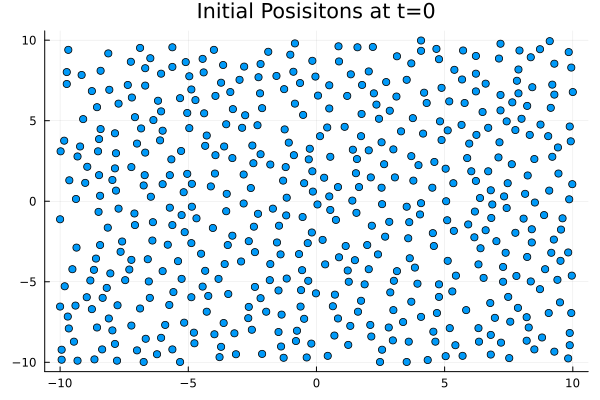

In [9]:
scatter(r[1,:,1], r[1,:,2], title="Initial Posisitons at t=0", legend=false)

#### <p style="text-align:center">Figur 3</p>

### Animasjon av Partiklenes Utvikling Over Tid


<a id='fig_sim'></a>

[ Info: Saved animation to C:\Users\oskar\OneDrive - Universitetet i Oslo\Dokumenter\GitHub\Privat\FYS2130-Svingninger-og-bolger\Comp. Essay\tmp.gif


Plots.AnimatedGif("C:\\Users\\oskar\\OneDrive - Universitetet i Oslo\\Dokumenter\\GitHub\\Privat\\FYS2130-Svingninger-og-bolger\\Comp. Essay\\tmp.gif")
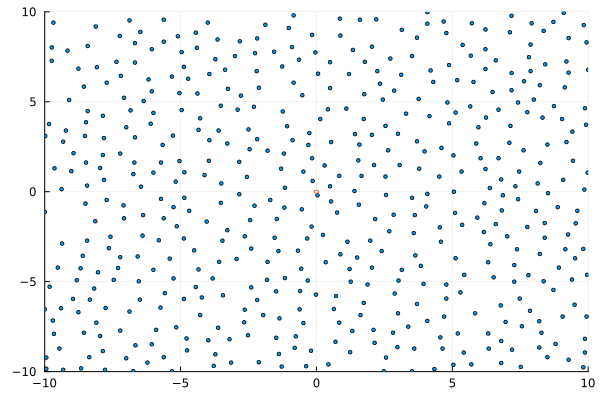

In [10]:
function analytial_solution(r)
"""
Funksjon som returnerer analytisk løsning for en sirkel med radius r
"""
    x = LinRange(0,2π,100)
    return r*sin.(x) , r*cos.(x)
end

# Animasjon av partiklenes bevegelse
@gif for i ∈ 1:steps
    rx = r[i,:,1]
    ry = r[i,:,2]
    scatter(rx,ry, xlim=(-l/2,l/2), ylim=(-l/2,l/2), markersize=2, legend=false)
    plot!(analytial_solution(i/12), xlim=(-l/2,l/2), ylim=(-l/2,l/2))
end

<a id='fig_E'></a>

#### <p style="text-align:center">Figur 4</p>

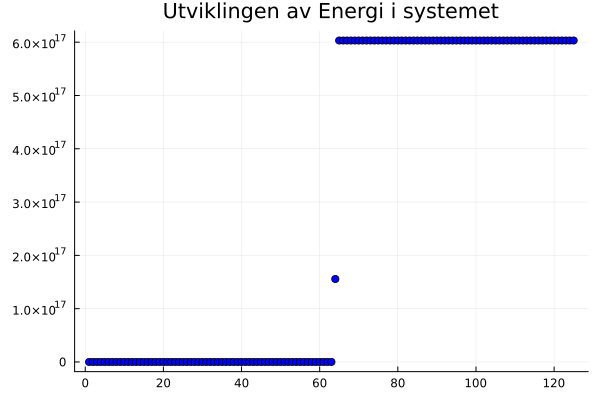

In [11]:
# Plot av Energien til systemet over tid. Har valgt å ignore koeffesienter for kinetisk energi, 
# og legger til LJ-Potensialet beregnet underveis. 
# Vi øsnker å se en relativt konstant utvikling så koeffesienter er uinteressant
p = scatter()
for i ∈ 1:steps
    E = sum(abs.(v[i,:,:]))^2 + u[i]
    scatter!((i,E), title="Utviklingen av Energi i systemet", label=false, color="blue")
end

display(p)

#### <p style="text-align:center">Figur 5</p>

<a id='fig_E'></a>

## Diskusjon

### Fysisk Utvikling av Systemet
Som vist i [Figur 3](#fig_init_pos) av initielle posisjoner, har vi klart å sette opp systemet som ønsket. I de første sekundene av animasjonen i [Figur 4](#fig_sim), som viser systemets utvikling, er det klart at partiklene har fått en radiell hastighet som planlagt. Så kommer vi dit hvor modellen ikke oppfører seg som forventet. Kreftene som virker mellom partiklene vokser helt ekstremt raskt og de akselereres enormt. Årsaken til dette har jeg ikke funnet noe god grunn for. Jeg forsøkte å korrigere noe av dette ved å multiplisere akselerasjonen med et veldig lite tall $10^{-13}$. Dette korrigerte noe av oppførselen, men over tid ble systemet kaotisk igjen. I [Figur 6](#fig_no_correction) kan du se systemet uten noe form for korreksjon i akselerasjon.

<a id='fig_no_correction'></a>

![test](Sim_no_correction.gif)

#### <p style="text-align:center">Figur 6</p>


Hvis jeg hadde implementert en måte for partiklene som forsvinner ut av boksen, å komme tilbake igjen kan det hende systemet hadde nådd et likevektspunkt over tid. 

Videre har vi den totale energien som sett i [Figur 5](#fig_E), som også vokser ekstremt.


### Numerisk Prestasjon
I selve koden er det flere ting som kunne ha blitt gjort bedre for å øke antall partikler og minske tidssteg. Denne typen simulasjoner er tungt numerisk arbeid. Derfor ønsket jeg å prøve et nytt kodespråk: Julia. Det kjører definitivt raskere enn python, men er langt fra å ha blitt brukt til sitt fulle potensialet. Bibliotek som [`CellListMap.jl`](https://github.com/m3g/CellListMap.jl) er optimalisert for oppdeling av boksen i mindre celler for raskere beregninger mellom partikler. Videre har vi ting som [`StaticArrays.jl`](https://www.juliapackages.com/p/staticarrays) som lar oss konstruere vektorer og matriser optimalisert for matematiske operasjoner. Begge disse tingene kunne jeg ha implementert i min egen kode, men valgte å ikke gjøre dette før jeg hadde en fungerende modell, ettersom det ville har ført til økt kompleksitet. Når modellen fungerer som den skal ville fokuset ha vært på å øke dets prestasjon. Ettersom simulasjonen bruker tre løkker, (én for anntal tidsteg, to for alle partikkel interaksjoner) er algoritmen av tidskompleksitet $O(n^2)$ for $n_p$ antall partikler multiplisert med en faktor av $O(n)$ for $n_t$ antall tidssteg. Dermed er det forventet at den vil være krevende. Hvis en finner en raskere måte å iterere over alle partiklene vil dette drastisk senke tiden det tar å kjøre simulasjonen. En kunne prøvd å parallelisere beregningene av interasksjonene mellom alle partiklene i hvert tisdssteg, ettersom de ikke er avhengig av hverandre, bare nåverende distanse. 

Vi klarer å simulere interaksjoner mellom 500 partikler, i 0.125 sekunder ved et tidssteg på 1 ms på ca 15 sekunder. Dette er greit for å kunne undersøke om en har en modell som fungerer, men for en realistisk simulasjon vil det kreve mange tusen til millioner av partikler. Flere andre har prøvd på lignende simulasjoner av interaksjoner mellom molekyler. I et [eksempel](https://m3g.github.io/2021_FortranCon/) gjort av Leandro Martínez fra Kjemisk Institutt på [Universitetet i Campinas](https://www.unicamp.br/unicamp/english/) viser at det er mulig å simulere 10 000 partikler. Dermed er det høyst sannsynlig denne modellen kan utbedres videre. 

## Konklusjon
For å oppnå en realistisk bølge vil det kreve en større boks, med flere partikler. Nøyaktig hvor mange er vanskelig å si ettersom simulasjonen er et stykke unna noe reelt. Som tidligere nevnt, er det vanlig å bruke flere tusen, til millioner av partikler så noe mer presist enn det er vanskelig å estimere. 

Den teoretiske bølgen med øsnket oppførsel var ikke mulig å beregne ettersom vi ikke hadde noe ordentlig fysisk system helt enda, så løsningen ble å ta ting litt på øyemål. Dette fungerte helt greit, ettersom det ga en viss følelse av ønsket oppførsel, som vi håpet. 

Energien i systemet blåser helt ut av proposjoner. Dette er et klart tegn om at noe er galt i de numeriske beregningene. 

Alt i alt var dette ikke en velykket simulasjon, ettersom den feilet på det fysiske og visuelle. Dermed er det ikke klart det er mulig å beregne bølger og partikler på denne skalaen. Likevel har mange andre klart å simulere interaskjoner mellom partikler på denne skalaen, og dermed er det ikke usannsynlig en kunne introdusert en bølge i disse systemene. 

## Kilder
Ettersom metodene brukt er veldig etablerte og kjente metoder og utrykk viser jeg til [Wikipedia](https://en.wikipedia.org/wiki/Wikipedia)-siden for disse. Her er det også linket videre til andre kilder, hvor metodene enten brukes og eller diskuteres. Dessverre er flere av disse kildene bak betalingsmurer, jeg ikke kommer rundt. 

<a id='LJ-pot'></a>

### 1. [Lennard-Jones Potensialet](https://en.wikipedia.org/wiki/Lennard-Jones_potential)
Eksempel på bruk av Lennard-Jones potensialet kan sees i [Computer Simulations of Liquid/Vapor Interface in Lennard-Jones Fluids](https://watermark.silverchair.com/8510_1_online.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAABPcwggTzBgkqhkiG9w0BBwagggTkMIIE4AIBADCCBNkGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMnPI4bRAAG6ibyt3FAgEQgIIEqpUH_MHPeIUaFtZlTFpSjlvClevcziVmZGGGMYtMjqh1aMzcZIhXojC4Z50SY_JG6-dmSt75wcNLSPfW3jEjiH10IUDLaw_QWW_WVGGzdMEjou6NEheG6jBeCaK_XEQX3VqZhdyTagB-XuqgnPsSrwg3GDReiN9D6ZeANYbEWxJaieqQ8yTxpGYocVuJi4TbeA0feQZ89jGF5QhNtiAv-FwU5AIX1ygVeYzmhcGQyQBLSbw-M34p2lKW_IWi2usBo9v-nPNYL0RECqsYzvtGC17ckyJe7E98WB1n2rKHgDSivJ3lR9SiynGp-oRH-1HIBZTYDF-2P5LNKvTo4iu-u8-KIv3gZi4LQqzKEfFsE6ADcvQG3qcu_D_Wr3D2PgZRPtWJ5Xdxy6D5emuSBCzptbCHnFiQBVh6GqAbhPbzskO-9bqLGODWvs9e4rfkdCWKxwD0eLW-DFmZOI13n-PmV3Sdq6DE0B3kN7NUfDUiR5xzPT_H510wSNBxOu8fKQSsIwN5gJgtmBbDoybPHKMlwJw4xWjHEL7xWEfAHhYZ47W2INuMUrW4jlY7aToEVXJymsIwk_Qu2RSwvmsz-eTK2GiK7v7XO2IX8AG8qWVPkZoe2LZN5NUKB88cTxn1QozUZgceLTDjry-9N2kmk9rO-C6Ks61eN6hCqL5k5RygVJbvkcGu8pnJcL4p5kqL-E3mcm9XxDtL-TWkXxCpiKYSZrTNmCl3gKTicHFDg6KnOTfWSsbuqzQo3icF_ZkEJZz60muM6w5XCjGXrJ1QW0aHGWbZhtDLnx2EX89BkU_IQKx1LZesZNfwDZQwzilHOKE3s4o9_Bchs6Fb-JeivWecV0_i8ubi7j2ySlHKF73FTRZHxqppy51sbURKBPqdEzOs5RiBxLgJJf-pTqpHw9vIjbvI45w5gK--i9TkJHxReOZFBJE6KiG7NLH1mjU9N8qn1h1UAsqj9xbqYhe75LsfEHYkweuQe9t9wkPzxHP3chc9-H11lCL53DoYgJQ9aeXRknIq2L_h1UWvVmumcl0dnyCctEeT_4rqyeAx8vp6ekfh8FL7uXwpvibWIc7LWDgUtBpK6mrUmmV-WhNle8XSZ6TL4kJOjKXRI2Y-5d0e3VrfvFTZpXkyEyMlZM9p8OPN-phCSYWn6PPrGqVyLg2sWF7WQkZNXg1ExgyS7Nb_z6DCo2tWJp4NbgQ6JFKRWuDSLuMUWeiB6GnK_rnoEYJD3fNoWdsXFrez60TwOUV848O_-lX-n43fRdblfN6Oi4G37Y9NFnxZ-xAT4Vn2x4fuGeRZJ-cG2WdnrwA5oiZTKzrwMiPzsOdAoEZ1gCVKAezF7u5-udKp2236BMCW13nK9xQ8HJkrkKFVeg5ZL8H92C8VT3966bBl5Liu3iqA8HpXuV_gfKYDI7g1y2U_87aOtFqfbwnoqzdpBmJnES33hF-0RqEoC2AbyymEbnMQzs538D0O6vx-sP_VW72Cl3qVEaGEmci_NtIMzP_XTzEwQAVcMEAZ0VCO2j1ZygB4kgeY49iVwceQhN7X6L4ZU6fgXEFCnSjmU69rO7PPnMkEodGTHMdZzhLgpV_IaA)



<a id='vel_ver'></a>

### 2. [Velocity Verlet Integration](https://en.wikipedia.org/wiki/Verlet_integration)
Eksempel på bruk av Velocity Verlet i molekylærdynamikk kan sees i [Classical Molecular Dynamics Simulation iwth the Velocity Verlet Algoritm](https://www.sciencedirect.com/science/article/abs/pii/S002199919996237X?via%3Dihub) (betallingsmur)

<a id='big_o'></a>

### 3. [Big O Notation](https://en.wikipedia.org/wiki/Big_O_notation#References_and_notes)
Videre forklaring av Big O Notaion kan leses i [An Introduction to Algorithms and the Big O Notation](https://link.springer.com/content/pdf/10.1007/978-3-319-17701-4_23.pdf)